In [ ]:
srun -G1 --pty bash -c "source /data/ai_club/team_3_2024-25/team3-env-finetune/bin/activate; \
    hostname; \
    jupyter notebook \
        --ServerApp.root_dir=$(pwd) \
        --ServerApp.password='' \
        --ServerApp.open_browser=False \
        --ServerApp.allow_origin='*' \
        --ServerApp.allow_remote_access=True \
        --ServerApp.port=14321 \
        --ServerApp.ip='*'
"

In [1]:
%env IM_MODE new-mask_ops2

import im_llm
import importlib
importlib.reload(im_llm)

from matplotlib import pyplot as plt
import json
import numpy as np

env: IM_MODE=new-mask_ops2


2025-03-15 18:17:59.878022: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 18:17:59.890732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742077079.906493 1314275 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742077079.911299 1314275 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 18:17:59.927191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
model, tokenize, tokenizer, tokof = im_llm.get_model()
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x IMDecoderLayer(
        (original_layer): Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear(in_features=896, out_features=896, bias=True)
            (k_proj): Linear(in_features=896, out_features=128, bias=True)
            (v_proj): Linear(in_features=896, out_features=128, bias=True)
            (o_proj): Linear(in_features=896, out_features=896, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
            (up_proj): Linear(in_features=896, out_features=4864, bias=False)
            (down_proj): Linear(in_features=4864, out_features=896, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        )
      )
   

In [232]:
for i, s in enumerate(im_llm.IMDecoderLayer.block_strength):
    c=3
    s.data.fill_(c*i/(i+c))

In [10]:
tokens = tokenize('Here\'s my story: I took the')
# tokens = tokenize('I don\'t like taking the')
# tokens = tokenize('Eat a balanced and nutritious')
# tokens = tokenize('Define canine. The')

im_llm.IMDecoderLayer.mask = im_llm.gen_mask(tokens)
# im_llm.IMDecoderLayer.mask[0][-1] += [tokof(' Dog'), tokof(' Ho'), tokof(' The'), tokof(' It')]

# out = model.generate(
out = model(
    **tokens,
    # labels=tokens['input_ids'],
    max_new_tokens=1,
    pad_token_id=tokenizer.eos_token_id,
    temperature=0.001,
    do_sample=True,
    return_dict_in_generate=True,
    output_hidden_states=True
)

# print(tokenizer.decode(out.sequences[0]))

print(
    out.logits[0][-1][tokof(' dog')]
)

tokenizer.decode(tokens['input_ids'][0]) +\
tokenizer.decode(out.logits[0][-1].argmax(dim=-1))

tensor(10.3487, device='cuda:0', grad_fn=<SelectBackward0>)


"Here's my story: I took the first"

### Simple english test

In [39]:
# Example one: ALL vocab (with AND without leading space) are single tokens - trivial case

vocab = [
    'the','be','to','of','and','a','in','that','have','I','it','for','not','on','with','he','as','you','do',
    'at','this','but','his','by','from','they','we','say','her','she','or','an','will','my','one','all','would',
    'there','their','what','so','up','out','if','about','who','get','which','go','me','when','make','can','like',
    'time','no','just','him','know','take','people','into','year','your','good','some','could','them','see','other',
    'than','then','now','look','only','come','its','over','think','also','back','after','use','two','how','our','work',
    'first','well','way','even','new','want','because','any','these','give','day','most','us',

    'apple', 'car', 'phone', 'bike', 'bus', 'store', 'park', 'school'
]

vocab += [' '+v for v in vocab]

vocab = [tokenizer.encode(v) for v in vocab]
assert all(len(v) == 1 for v in vocab)
vocab = [v[0] for v in vocab]

In [72]:
for i, s in enumerate(im_llm.IMDecoderLayer.block_strength):
    c = 1.5
    s.data.fill_(c*i/(i+c))

In [91]:
prompt = 'Here\'s my story:'

print(prompt, end='')

for _ in range (55):
    tokens = tokenize(prompt)

    im_llm.IMDecoderLayer.mask = im_llm.gen_mask(tokens)
    im_llm.IMDecoderLayer.mask[0][-1] += vocab + [tokof('.'), tokof(','), tokof('<|endoftext|>')]

    # out = model.generate(
    out = model(
        **tokens,
        # labels=tokens['input_ids'],
        max_new_tokens=1,
        pad_token_id=tokenizer.eos_token_id,
        temperature=1,
        # repetition_penalty=10,
        # temperature=0.001,
        do_sample=True,
        return_dict_in_generate=True,
        output_hidden_states=True
    )

    # print(tokenizer.decode(out.sequences[0]))

    # print(
    #     out.logits[0][-1][tokof(' dog')]
    # )

    logits = out.logits[0][-1]
    logits[vocab] += 100

    tok = tokenizer.decode(logits.argmax(dim=-1))

    # tok = tokenizer.decode(out.sequences[0][-1])

    prompt += tok

    print(tok, end='')

Here's my story: I have a new car and I have to go to the car park

 to park it and I have to go to the car park to get my car back and I have to go to the car park to get my car to the car park and so on and so on and

### Moderate english test

Not 1-1 vocab-token mapping

In [267]:
vocab = [
    'the','be','to','of','and','a','in','that','have','I','it','for','not','on','with','he','as','you','do',
    'at','this','but','his','by','from','they','we','say','her','she','or','an','will','my','one','all','would',
    'there','their','what','so','up','out','if','about','who','get','which','go','me','when','make','can','like',
    'time','no','just','him','know','take','people','into','year','your','good','some','could','them','see','other',
    'than','then','now','look','only','come','its','over','think','also','back','after','use','two','how','our','work',
    'first','well','way','even','new','want','because','any','these','give','day','most','us',
    # *list(',.?!":;') # IDEA: separate "delimiters" list including spaces
]

vocab = [tokenizer.encode(v) for v in vocab]

vocab_tree = []

# vocab

In [253]:
# This would come from detokenization of current output - this could be sped up be detokenizing from end back until you have most recent word.

'''
EXPECTING these as next:
re
y
ir
m
n
se
<space><start of any vocab>
'''

to_continue = 'they give us the'

In [255]:
to_continue.split()[-1]

'the'

In [ ]:
tokens = tokenize('????')

im_llm.IMDecoderLayer.mask = im_llm.gen_mask(tokens)
im_llm.IMDecoderLayer.mask[0][-1] += [tokof(' Dog'), tokof(' Ho'), tokof(' The'), tokof(' It')]

# out = model.generate(
out = model(
    **tokens,
    # labels=tokens['input_ids'],
    max_new_tokens=1,
    pad_token_id=tokenizer.eos_token_id,
    temperature=0.001,
    do_sample=True,
    return_dict_in_generate=True,
    output_hidden_states=True
)

# print(tokenizer.decode(out.sequences[0]))

print(
    out.logits[0][-1][tokof(' dog')]
)

tokenizer.decode(tokens['input_ids'][0]) +\
tokenizer.decode(out.logits[0][-1].argmax(dim=-1))

---

In [12]:
v2e = model.model.embed_tokens.weight
e2v = model.lm_head.weight.T

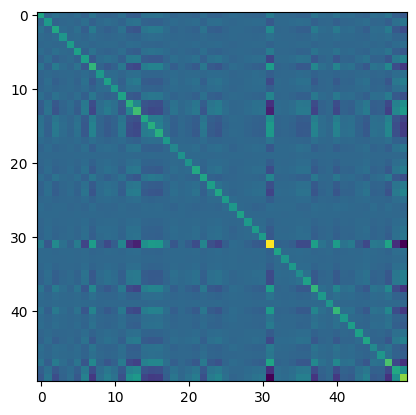

tensor([[36.7502, -1.6050,  4.1611,  ..., -2.5718, -2.5552,  6.4614],
        [-1.6050, 30.1078, -2.9366,  ...,  2.1243,  2.2632, -4.9801],
        [ 4.1611, -2.9366, 38.9741,  ..., -4.3922, -4.2554,  9.4764],
        ...,
        [-2.5718,  2.1243, -4.3922,  ..., 31.7548,  4.1047, -7.6417],
        [-2.5552,  2.2632, -4.2554,  ...,  4.1047, 36.2600, -7.2742],
        [ 6.4614, -4.9801,  9.4764,  ..., -7.6417, -7.2742, 32.3975]],
       device='cuda:0')

In [41]:
mul = e2v@v2e

plt.imshow(mul.cpu()[:50, :50]) ; plt.show()

mul

In [109]:
ref = None
for other in ['France', 'dog', 'hound', 'can', 'the']:
    emb1 = v2e[tokof('French')]
    emb2 = v2e[tokof(other)]
    # emb2 = e2v[:, tokof(other)]
    
    emb1 = emb1/emb1.norm()
    emb2 = emb2/emb1.norm()
    
    sim = float(emb1.dot(emb2))

    if ref == None:
        ref = sim

    sim /= ref
    print(other, sim, sep='\t')

print()

ref = None
for other in ['dog', 'hound', 'can', 'the', 'France']:
    emb1 = v2e[tokof('dog')]
    emb2 = v2e[tokof(other)]
    # emb2 = e2v[:, tokof(other)]
    
    emb1 = emb1/emb1.norm()
    emb2 = emb2/emb1.norm()
    
    sim = float(emb1.dot(emb2))

    if ref == None:
        ref = sim

    sim /= ref
    print(other, sim, sep='\t')

France	1.0
dog	0.2896868293438655
hound	0.331612582589084
can	0.11267439697430738
the	-0.0005257636852334243

dog	1.0
hound	0.34396531545733094
can	0.116936423593747
the	0.007971994846461739
France	0.15332368183807812


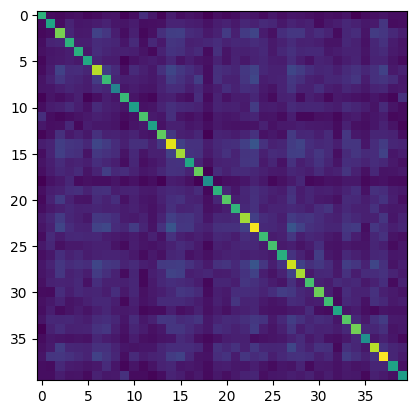

array([[0.1904796 , 0.00519331, 0.0031682 , ..., 0.01291147, 0.00644688,
        0.00712628],
       [0.00519331, 0.17308916, 0.00648572, ..., 0.0424947 , 0.00492179,
        0.0065205 ],
       [0.0031682 , 0.00648572, 0.23517272, ..., 0.04301716, 0.0305109 ,
        0.02016101],
       ...,
       [0.01291147, 0.0424947 , 0.04301716, ..., 0.29725724, 0.02624369,
        0.01719019],
       [0.00644688, 0.00492179, 0.0305109 , ..., 0.02624369, 0.16938277,
        0.00846689],
       [0.00712628, 0.0065205 , 0.02016101, ..., 0.01719019, 0.00846689,
        0.1640104 ]], dtype=float32)

In [33]:
center = 18457
lo, hi = center-20, center+20

mul2 = np.array([
    [
        v2e[i].dot(e2v[:,j]).cpu()
        for i in range(lo, hi)
    ]
    for j in range(lo, hi)
])

plt.imshow(mul2) ; plt.show()

mul2